In [57]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *

In [58]:
# Load data
df = pd.read_csv('bhiwandi_tsp_nodes.csv')
df.head()

,Location,Latitude,Longitude
0,Bhiwandi (Depot),19.2813,73.0483
1,Thane,19.2183,72.9781
2,Kalyan,19.2403,73.1305
3,Dombivli,19.2189,73.0867
4,Ulhasnagar,19.2167,73.1500


In [59]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [60]:
places_coords = {row[0]: (row[1], row[2]) for row in df.values}

places = list(places_coords.keys())
dist = {}
for i in places:
    for j in places:
        if i != j:
            dist[i, j] = haversine(*places_coords[i], *places_coords[j])

print("Haversine Distances:")
print(dist)

Haversine Distances:
{('Bhiwandi (Depot)', 'Thane'): np.float64(10.167736200398249), ('Bhiwandi (Depot)', 'Kalyan'): np.float64(9.758965924271982), ('Bhiwandi (Depot)', 'Dombivli'): np.float64(8.024576280933035), ('Bhiwandi (Depot)', 'Ulhasnagar'): np.float64(12.867867228756559), ('Bhiwandi (Depot)', 'Ambernath'): np.float64(17.85917331856164), ('Bhiwandi (Depot)', 'Badlapur'): np.float64(26.738287826659345), ('Bhiwandi (Depot)', 'Airoli'): np.float64(14.8111329935334), ('Bhiwandi (Depot)', 'Ghansoli'): np.float64(17.69746116631025), ('Bhiwandi (Depot)', 'Virar'): np.float64(34.981586909510774), ('Bhiwandi (Depot)', 'Vashi'): np.float64(23.29822569319474), ('Bhiwandi (Depot)', 'Turbhe'): np.float64(21.886651240787423), ('Bhiwandi (Depot)', 'Nerul'): np.float64(27.78893767322068), ('Bhiwandi (Depot)', 'Mulund'): np.float64(15.446223042785933), ('Bhiwandi (Depot)', 'Bhandup'): np.float64(18.83303401625264), ('Bhiwandi (Depot)', 'Ghatkopar'): np.float64(26.42129927478115), ('Bhiwandi (Dep

In [61]:
n = len(places_coords)
d = [[0 for _ in range(n)] for _ in range(n)]

locations = df['Location'].tolist()
latitudes = df['Latitude'].tolist()
longitudes = df['Longitude'].tolist()

# Create a dictionary to map location names to coordinates
coord_dict = {loc: (lat, lon) for loc, lat, lon in zip(locations, latitudes, longitudes)}

In [62]:
solver = SolverFactory("cbc", executable=r"C:\Users\maiti\Downloads\Cbc-releases.2.10.12-w64-msvc16-md\bin\cbc.exe")

In [63]:
# DFJ Formulation
model = ConcreteModel()
model.nodes = Set(initialize=places)
model.x = Var(model.nodes, model.nodes, within=Binary)

# Objective
model.obj = Objective(expr=sum(dist[i, j] * model.x[i, j] for i in places for j in places if i != j), sense=minimize)

# Constraints
model.constraints = ConstraintList()
for i in places:
    model.constraints.add(sum(model.x[i, j] for j in places if j != i) == 1)
    model.constraints.add(sum(model.x[j, i] for j in places if j != i) == 1)

# Solve 
start_time = time.time()
results = solver.solve(model)
solve_time1 = time.time() - start_time

# Initial solution (without subtour elimination)
edges_initial = []
total_distance_initial = 0
for i in places:
    for j in places:
        if i != j and model.x[i, j].value > 0.5:
            edges_initial.append((i, j))
            total_distance_initial += dist[i, j]

print("Initial Solution (without subtour elimination):")
print(edges_initial)
print("Total Distance:", total_distance_initial)

Initial Solution (without subtour elimination):
[('Bhiwandi (Depot)', 'Dombivli'), ('Thane', 'Virar'), ('Kalyan', 'Ulhasnagar'), ('Dombivli', 'Bhiwandi (Depot)'), ('Ulhasnagar', 'Kalyan'), ('Ambernath', 'Badlapur'), ('Badlapur', 'Ambernath'), ('Airoli', 'Ghansoli'), ('Ghansoli', 'Airoli'), ('Virar', 'Thane'), ('Vashi', 'Turbhe'), ('Turbhe', 'Vashi'), ('Nerul', 'Panvel'), ('Mulund', 'Bhandup'), ('Bhandup', 'Mulund'), ('Ghatkopar', 'Powai'), ('Powai', 'Ghatkopar'), ('Kurla', 'Chembur'), ('Chembur', 'Kurla'), ('Panvel', 'Nerul')]
Total Distance: 159.96629227082934


In [64]:
# Find subtour
def find_subtour(edges, places):
    visited = set()
    subtour = []
    for start in places:
        if start not in visited:
            tour = []
            node = start
            while node not in tour:
                tour.append(node)
                visited.add(node)
                for j in places:
                    if (node, j) in edges:
                        node = j
                        break
            subtour.append(tour)
    return subtour

subtour = find_subtour(edges_initial, places)

# Subtour elimination
while len(subtour) > 1:
    for s in subtour:
        if len(s) < len(places):
            model.constraints.add(sum(model.x[i, j] for i in s for j in s if i != j) <= len(s) - 1)
    results = solver.solve(model)
    
    edges = []
    total_distance = 0
    for i in places:
        for j in places:
            if i != j and model.x[i, j].value > 0.5:
                edges.append((i, j))
                total_distance += dist[i, j]
    
    subtour = find_subtour(edges, places)

print("\nFinal Solution (after subtour elimination):")
print(edges)
print("Total Distance:", total_distance)


Final Solution (after subtour elimination):
[('Bhiwandi (Depot)', 'Dombivli'), ('Thane', 'Virar'), ('Kalyan', 'Ulhasnagar'), ('Dombivli', 'Kalyan'), ('Ulhasnagar', 'Ambernath'), ('Ambernath', 'Badlapur'), ('Badlapur', 'Panvel'), ('Airoli', 'Ghatkopar'), ('Ghansoli', 'Airoli'), ('Virar', 'Bhiwandi (Depot)'), ('Vashi', 'Turbhe'), ('Turbhe', 'Ghansoli'), ('Nerul', 'Vashi'), ('Mulund', 'Thane'), ('Bhandup', 'Mulund'), ('Ghatkopar', 'Chembur'), ('Powai', 'Bhandup'), ('Kurla', 'Powai'), ('Chembur', 'Kurla'), ('Panvel', 'Nerul')]
Total Distance: 187.30549368543444


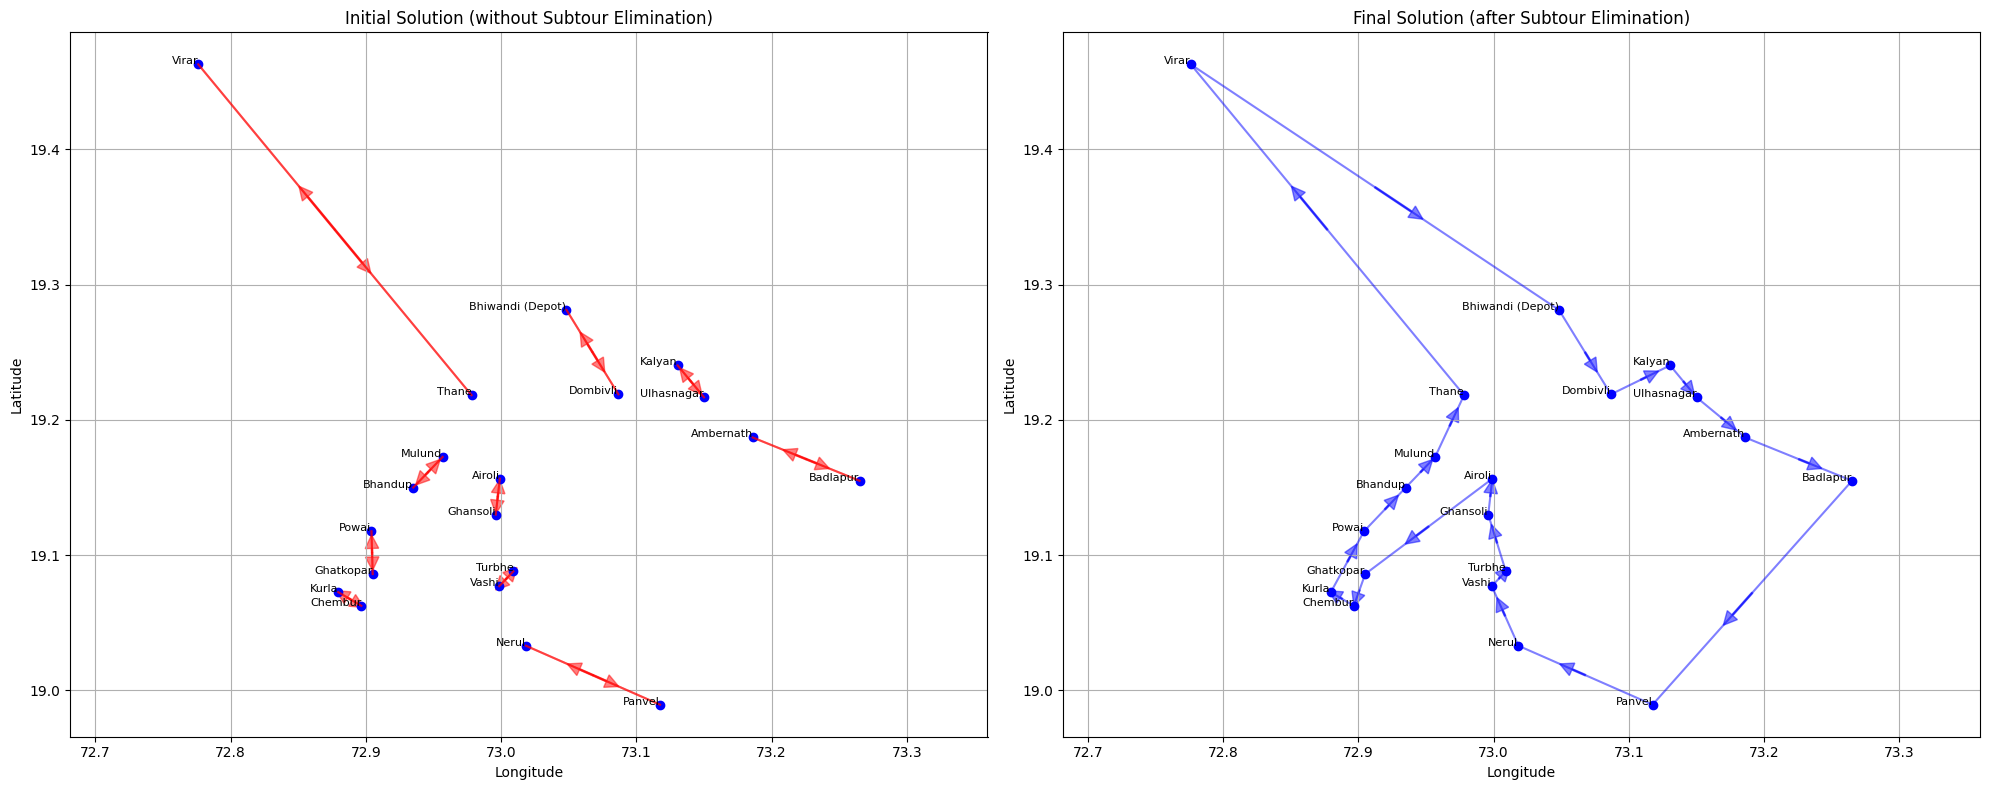

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Initial Solution (without subtour elimination)
for i, loc in enumerate(locations):
    lat, lon = coord_dict[loc]
    ax1.plot(lon, lat, 'bo', label=loc if i == 0 else "")
    ax1.text(lon, lat, loc, fontsize=8, ha='right')
for i, j in edges_initial:
    lat_i, lon_i = coord_dict[i]
    lat_j, lon_j = coord_dict[j]
    ax1.plot([lon_i, lon_j], [lat_i, lat_j], 'r-', alpha=0.5)
    mid_lon = (lon_i + lon_j) / 2
    mid_lat = (lat_i + lat_j) / 2
    dx = (lon_j - lon_i) * 0.1
    dy = (lat_j - lat_i) * 0.1
    ax1.arrow(mid_lon, mid_lat, dx, dy, head_width=0.01, head_length=0.01, fc='red', ec='red', alpha=0.5)
ax1.set_title('Initial Solution (without Subtour Elimination)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True)
ax1.axis('equal')

# Plot Final Solution (after subtour elimination)
for i, loc in enumerate(locations):
    lat, lon = coord_dict[loc]
    ax2.plot(lon, lat, 'bo', label=loc if i == 0 else "")
    ax2.text(lon, lat, loc, fontsize=8, ha='right')
for i, j in edges:
    lat_i, lon_i = coord_dict[i]
    lat_j, lon_j = coord_dict[j]
    ax2.plot([lon_i, lon_j], [lat_i, lat_j], color='blue', alpha=0.5)
    mid_lon = (lon_i + lon_j) / 2
    mid_lat = (lat_i + lat_j) / 2
    dx = (lon_j - lon_i) * 0.1
    dy = (lat_j - lat_i) * 0.1
    ax2.arrow(mid_lon, mid_lat, dx, dy, head_width=0.01, head_length=0.01, fc='blue', ec='blue', alpha=0.5)
ax2.set_title('Final Solution (after Subtour Elimination)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True)
ax2.axis('equal')

plt.tight_layout()
plt.show()

In [66]:
# MTZ Formulation
model = ConcreteModel()
model.nodes = Set(initialize=places)
model.x = Var(model.nodes, model.nodes, within=Binary)
model.u = Var(model.nodes, within=NonNegativeIntegers)

# Objective
model.obj = Objective(expr=sum(dist[i, j] * model.x[i, j] for i in places for j in places if i != j), sense=minimize)

# Constraints
model.constraints = ConstraintList()
for i in places:
    model.constraints.add(sum(model.x[i, j] for j in places if j != i) == 1)
    model.constraints.add(sum(model.x[j, i] for j in places if j != i) == 1)

for i in places:
    if i != places[0]: 
        model.constraints.add(model.u[i] >= 1)
        model.constraints.add(model.u[i] <= len(places) - 1)

for i in places:
    for j in places:
        if i != j and i != places[0] and j != places[0]:
            model.constraints.add(model.u[i] - model.u[j] + len(places) * model.x[i, j] <= len(places) - 1)

start_time = time.time()
results = solver.solve(model)
solve_time2 = time.time() - start_time

edges = []
total_distance = 0
for i in places:
    for j in places:
        if i != j and model.x[i, j].value > 0.5:
            edges.append((i, j))
            total_distance += dist[i, j]

print("Optimal Tour (MTZ Formulation):")
print(edges)
print("Total Distance Travelled:", total_distance, "km")

Optimal Tour (MTZ Formulation):
[('Bhiwandi (Depot)', 'Virar'), ('Thane', 'Mulund'), ('Kalyan', 'Dombivli'), ('Dombivli', 'Bhiwandi (Depot)'), ('Ulhasnagar', 'Kalyan'), ('Ambernath', 'Ulhasnagar'), ('Badlapur', 'Ambernath'), ('Airoli', 'Ghansoli'), ('Ghansoli', 'Turbhe'), ('Virar', 'Thane'), ('Vashi', 'Nerul'), ('Turbhe', 'Vashi'), ('Nerul', 'Panvel'), ('Mulund', 'Bhandup'), ('Bhandup', 'Powai'), ('Ghatkopar', 'Airoli'), ('Powai', 'Kurla'), ('Kurla', 'Chembur'), ('Chembur', 'Ghatkopar'), ('Panvel', 'Badlapur')]
Total Distance Travelled: 187.3054936854344 km


In [67]:
# 3-Index Formulation
model = ConcreteModel()
model.nodes = Set(initialize=range(n))
model.x = Var(model.nodes, model.nodes, model.nodes, within=Binary)

# Objective
model.obj = Objective(expr=sum(dist[(places[i], places[j])] * model.x[i, j, k] for i in range(n) for j in range(n) for k in range(n) if i != j), sense=minimize)

# Constraints
model.constraints = ConstraintList()
for i in range(n):
    model.constraints.add(sum(model.x[i, j, k] for j in range(n) for k in range(n) if i != j) == 1)
    model.constraints.add(sum(model.x[j, i, k] for j in range(n) for k in range(n) if i != j) == 1)

# Exactly one edge per step
for k in range(n):
    model.constraints.add(sum(model.x[i, j, k] for i in range(n) for j in range(n) if i != j) == 1)

# Path continuity
for j in range(n):
    for k in range(n - 1):
        model.constraints.add(sum(model.x[i, j, k] for i in range(n) if i != j) == sum(model.x[j, q, k+1] for q in range(n) if q != j))

# Start and end constraints
model.constraints.add(sum(model.x[0, j, 0] for j in range(1, n)) == 1)
model.constraints.add(sum(model.x[i, 0, n - 1] for i in range(1, n)) == 1)

# No self-loops
for i in range(n):
    for k in range(n):
        model.constraints.add(model.x[i, i, k] == 0)

start_time = time.time()
results = solver.solve(model)
solve_time3 = time.time() - start_time

# Calculate total distance and edges from the solution
total_distance = 0
edges = []
for i in range(n):
    for j in range(n):
        for k in range(n):
            if i != j and model.x[i, j, k].value > 0.5:
                edges.append((places[i], places[j]))
                total_distance += dist[(places[i], places[j])]

print("3-Index Formulation:")
print(edges)
print("Total Distance:", total_distance, "km")

3-Index Formulation:
[('Bhiwandi (Depot)', 'Dombivli'), ('Thane', 'Virar'), ('Kalyan', 'Ulhasnagar'), ('Dombivli', 'Kalyan'), ('Ulhasnagar', 'Ambernath'), ('Ambernath', 'Badlapur'), ('Badlapur', 'Panvel'), ('Airoli', 'Ghatkopar'), ('Ghansoli', 'Airoli'), ('Virar', 'Bhiwandi (Depot)'), ('Vashi', 'Turbhe'), ('Turbhe', 'Ghansoli'), ('Nerul', 'Vashi'), ('Mulund', 'Thane'), ('Bhandup', 'Mulund'), ('Ghatkopar', 'Chembur'), ('Powai', 'Bhandup'), ('Kurla', 'Powai'), ('Chembur', 'Kurla'), ('Panvel', 'Nerul')]
Total Distance: 187.30549368543444 km


In [68]:
# **DFJ Model (LP Relaxation)**
model1 = ConcreteModel()
model1.nodes = Set(initialize=places)
model1.x = Var(model1.nodes, model1.nodes, within=NonNegativeReals, bounds=(0, 1))

model1.obj = Objective(expr=sum(dist[(i, j)] * model1.x[i, j] for i in places for j in places if i != j), sense=minimize)

model1.constraints = ConstraintList()
for i in places:
    model1.constraints.add(sum(model1.x[i, j] for j in places if j != i) == 1)
    model1.constraints.add(sum(model1.x[j, i] for j in places if j != i) == 1)

solver = SolverFactory('gurobi')
solver.solve(model1)
relaxation_bound1 = model1.obj.expr()

# **MTZ Model (LP Relaxation)**
model2 = ConcreteModel()
model2.nodes = Set(initialize=places)
model2.x = Var(model2.nodes, model2.nodes, within=NonNegativeReals, bounds=(0, 1))
model2.u = Var(model2.nodes, within=NonNegativeReals)

model2.obj = Objective(expr=sum(dist[(i, j)] * model2.x[i, j] for i in places for j in places if i != j), sense=minimize)

model2.constraints = ConstraintList()
for i in places:
    model2.constraints.add(sum(model2.x[i, j] for j in places if j != i) == 1)
    model2.constraints.add(sum(model2.x[j, i] for j in places if j != i) == 1)

for i in places:
    if i != places[0]:  # Avoid starting node (Bhiwandi)
        model2.constraints.add(model2.u[i] >= 1)
        model2.constraints.add(model2.u[i] <= len(places) - 1)

for i in places:
    for j in places:
        if i != j and i != places[0] and j != places[0]:
            model2.constraints.add(model2.u[i] - model2.u[j] + len(places) * model2.x[i, j] <= len(places) - 1)

solver.solve(model2)
relaxation_bound2 = model2.obj.expr()

# **3-Index Formulation (LP Relaxation)**
model3 = ConcreteModel()
model3.nodes = Set(initialize=range(n))
model3.x = Var(model3.nodes, model3.nodes, model3.nodes, within=NonNegativeReals, bounds=(0, 1))

model3.obj = Objective(expr=sum(dist[(places[i], places[j])] * model3.x[i, j, k] for i in range(n) for j in range(n) for k in range(n) if i != j), sense=minimize)

model3.constraints = ConstraintList()
for i in range(n):
    model3.constraints.add(sum(model3.x[i, j, k] for j in range(n) for k in range(n) if i != j) == 1)
    model3.constraints.add(sum(model3.x[j, i, k] for j in range(n) for k in range(n) if i != j) == 1)

for k in range(n):
    model3.constraints.add(sum(model3.x[i, j, k] for i in range(n) for j in range(n) if i != j) == 1)

for j in range(n):
    for k in range(n - 1):
        model3.constraints.add(sum(model3.x[i, j, k] for i in range(n) if i != j) == sum(model3.x[j, q, k+1] for q in range(n) if q != j))

model3.constraints.add(sum(model3.x[0, j, 0] for j in range(1, n)) == 1)
model3.constraints.add(sum(model3.x[i, 0, n - 1] for i in range(1, n)) == 1)

for i in range(n):
    for k in range(n):
        model3.constraints.add(model3.x[i, i, k] == 0)

solver.solve(model3)
relaxation_bound3 = model3.obj.expr()

print("LP Relaxation Bound Comparison:")
print(f"DFJ Formulation: {relaxation_bound1:.2f}")
print(f"MTZ Formulation: {relaxation_bound2:.2f}")
print(f"3-Index Formulation: {relaxation_bound3:.2f}")

LP Relaxation Bound Comparison:
DFJ Formulation: 159.97
MTZ Formulation: 161.81
3-Index Formulation: 168.48


In [69]:
print(f"Time taken to solve DFJ Formulation: {solve_time1:.4f}")
print(f"Time taken to solve MTZ Formulation: {solve_time2:.4f}")
print(f"Time taken to solve 3-Index Formulation: {solve_time3:.4f}")

Time taken to solve DFJ Formulation: 0.1406
Time taken to solve MTZ Formulation: 5.3280
Time taken to solve 3-Index Formulation: 16.3815


In [70]:
!pip install ortools

In [71]:
# OR Tools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

latitudes = df['Latitude'].to_numpy()
longitudes = df['Longitude'].to_numpy()

# Create distance matrix
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            dist_matrix[i][j] = haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
        else:
            dist_matrix[i][j] = 0

# Scale distances to integers 
dist_matrix = (dist_matrix * 1000).astype(int) 

# Define distance callback for OR-Tools
def create_distance_callback(dist_matrix, manager):
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return dist_matrix[from_node][to_node]
    return distance_callback

# Main TSP solver function
def solve_tsp():
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)  # 1 vehicle, start at depot (index 0)

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Register distance callback
    distance_callback = create_distance_callback(dist_matrix, manager)
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.solution_limit = 100

    # Solve the problem with timing
    start_time = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    solve_time = time.time() - start_time

    # Extract and print the solution
    if solution:
        print("Optimal Route:")
        total_distance = 0
        index = routing.Start(0)
        route = [places[manager.IndexToNode(index)]]
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route.append(places[manager.IndexToNode(index)])
            total_distance += dist_matrix[manager.IndexToNode(previous_index)][manager.IndexToNode(index)]
        print(" -> ".join(route))
        print(f"Total Distance: {total_distance / 1000:.2f} km")
        print(f"Solve Time: {solve_time:.2f} seconds")
    else:
        print("No solution found.")

# Run the solver
if __name__ == "__main__":
    solve_tsp()

Optimal Route:
Bhiwandi (Depot) -> Dombivli -> Kalyan -> Ulhasnagar -> Ambernath -> Badlapur -> Panvel -> Nerul -> Vashi -> Turbhe -> Ghansoli -> Airoli -> Ghatkopar -> Chembur -> Kurla -> Powai -> Bhandup -> Mulund -> Thane -> Virar -> Bhiwandi (Depot)
Total Distance: 187.29 km
Solve Time: 0.11 seconds
